# CarePath AI - Rapport de Benchmark des Modeles

## Objectif du notebook
Ce notebook presente, de maniere claire et professionnelle, les performances des politiques de routage testees dans CarePath AI:
- **PPO** (Reinforcement Learning),
- **Heuristic** (regles expertes),
- **Random** (baseline de reference).

Le document est concu pour:
- des profils techniques (validation des KPI),
- un public non technique (lecture guidee),
- un jury de hackathon (decision rapide et argumentee).


## Comment lire ce rapport

1. **Contexte et definitions KPI**: ce que mesure chaque metrique.
2. **Chargement des resultats**: import automatique des benchmarks JSON.
3. **Comparaisons visuelles**: reward, delais, equite, score composite.
4. **Synthese automatique**: gagnant par scenario et recommandation finale.


## Definitions des KPI

- **avg_reward_per_episode**: score global appris/optimise. *Plus haut (moins negatif) = meilleur*.
- **avg_travel**: temps moyen de trajet. *Plus bas = meilleur*.
- **avg_wait**: temps moyen d'attente. *Plus bas = meilleur*.
- **entropy_norm**: dispersion des destinations. *Plus haut = meilleure repartition*.
- **hhi**: concentration des destinations. *Plus bas = meilleure equite*.
- **composite_score**: score multi-criteres calcule dans le pipeline benchmark. *Plus bas = meilleur*.


In [18]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 180)
plt.style.use('ggplot')

ROOT = Path.cwd()
if not (ROOT / 'backend').exists():
    ROOT = ROOT.parent
DOCS_DIR = ROOT / 'backend' / 'docs'
DOCS_DIR


WindowsPath('c:/Users/lenovo/Documents/ECC/Hackathons/AGORAI HACKATHON/CarePath AI/backend/docs')

In [19]:
benchmark_files = sorted([
    p for p in DOCS_DIR.glob('*.json')
    if 'benchmark' in p.name.lower()
])

print(f'Benchmarks detectes: {len(benchmark_files)}')
for p in benchmark_files:
    print('-', p.name)


Benchmarks detectes: 6
- final_benchmark_kenya.json
- final_benchmark_kenya_mapped.json
- final_benchmark_kenya_mapped_v2.json
- final_benchmark_kenya_mapped_v3.json
- smoke_benchmark_real_only.json
- smoke_benchmark_real_only_after_cleanup.json


In [20]:
def parse_benchmark(path: Path):
    payload = json.loads(path.read_text(encoding='utf-8'))

    composite_by_policy = {}
    for item in payload.get('ranking_composite', []):
        pol = item.get('policy')
        score = item.get('composite', {}).get('composite_score')
        composite_by_policy[pol] = score

    rows = []
    for policy, m in payload.get('metrics', {}).items():
        rows.append({
            'file': path.name,
            'scenario': path.stem,
            'episodes': payload.get('episodes'),
            'source': payload.get('config', {}).get('source'),
            'speciality': payload.get('config', {}).get('speciality'),
            'policy': policy,
            'avg_reward_per_episode': m.get('avg_reward_per_episode'),
            'avg_overloads_per_episode': m.get('avg_overloads_per_episode'),
            'avg_travel': m.get('avg_travel'),
            'avg_wait': m.get('avg_wait'),
            'failure_rate': m.get('failure_rate'),
            'fallback_rate': m.get('fallback_rate'),
            'entropy_norm': m.get('entropy_norm'),
            'hhi': m.get('hhi'),
            'composite_score': composite_by_policy.get(policy),
            'destination_count': len(m.get('destination_distribution', {}) or {}),
        })
    return rows

rows = []
for bf in benchmark_files:
    try:
        rows.extend(parse_benchmark(bf))
    except Exception as e:
        print(f'[WARN] lecture ignoree pour {bf.name}: {e}')

df = pd.DataFrame(rows)
df.head()


,file,scenario,episodes,source,speciality,policy,avg_reward_per_episode,avg_overloads_per_episode,avg_travel,avg_wait,failure_rate,fallback_rate,entropy_norm,hhi,composite_score,destination_count
0,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,ppo,-71.640000,0.0,17.375000,72.1750,0.0,0.0,0.978454,0.213438,0.691321,5
1,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,heuristic,-73.590000,0.0,11.087500,80.9000,0.0,0.0,0.884444,0.263750,2.152508,5
2,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,random,-74.231333,0.0,20.941667,71.8475,0.0,0.0,0.999646,0.200227,1.800000,5
3,final_benchmark_kenya_mapped.json,final_benchmark_kenya_mapped,30,GEO_node_8891905584,maternal,ppo,-96.400000,0.0,19.500000,101.0000,0.0,0.0,0.811278,0.625000,1.656222,2
4,final_benchmark_kenya_mapped.json,final_benchmark_kenya_mapped,30,GEO_node_8891905584,maternal,heuristic,-62.290000,0.0,20.325000,57.5375,0.0,0.0,0.986250,0.209687,0.494673,5


## Controle qualite des donnees chargees


In [21]:
if df.empty:
    print('Aucune donnee benchmark disponible.')
else:
    print('Nombre de lignes:', len(df))
    print('Scenarios:', df['scenario'].nunique())
    print('Policies:', sorted(df['policy'].unique().tolist()))
    display(df.isna().sum().to_frame('missing_values'))


Nombre de lignes: 18
Scenarios: 6
Policies: ['heuristic', 'ppo', 'random']


,missing_values
file,0
scenario,0
episodes,0
source,0
speciality,0
policy,0
avg_reward_per_episode,0
avg_overloads_per_episode,0
avg_travel,0
avg_wait,0


## Vue detaillee (table principale)


In [22]:
if not df.empty:
    display(df.sort_values(['scenario', 'policy']).reset_index(drop=True))


,file,scenario,episodes,source,speciality,policy,avg_reward_per_episode,avg_overloads_per_episode,avg_travel,avg_wait,failure_rate,fallback_rate,entropy_norm,hhi,composite_score,destination_count
0,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,heuristic,-73.590000,0.0,11.087500,80.900000,0.0,0.0,0.884444,0.263750,2.152508,5
1,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,ppo,-71.640000,0.0,17.375000,72.175000,0.0,0.0,0.978454,0.213438,0.691321,5
2,final_benchmark_kenya.json,final_benchmark_kenya,30,GEO_node_8891905584,maternal,random,-74.231333,0.0,20.941667,71.847500,0.0,0.0,0.999646,0.200227,1.800000,5
3,final_benchmark_kenya_mapped.json,final_benchmark_kenya_mapped,30,GEO_node_8891905584,maternal,heuristic,-62.290000,0.0,20.325000,57.537500,0.0,0.0,0.986250,0.209687,0.494673,5
4,final_benchmark_kenya_mapped.json,final_benchmark_kenya_mapped,30,GEO_node_8891905584,maternal,ppo,-96.400000,0.0,19.500000,101.000000,0.0,0.0,0.811278,0.625000,1.656222,2
5,final_benchmark_kenya_mapped.json,final_benchmark_kenya_mapped,30,GEO_node_8891905584,maternal,random,-195.416667,0.0,227.197083,17.073750,0.0,0.0,0.998939,0.083774,1.600000,12
6,final_benchmark_kenya_mapped_v2.json,final_benchmark_kenya_mapped_v2,40,GEO_node_8891905584,maternal,heuristic,-70.027924,0.0,20.325000,57.537500,0.0,0.0,0.986250,0.209687,1.426937,5
7,final_benchmark_kenya_mapped_v2.json,final_benchmark_kenya_mapped_v2,40,GEO_node_8891905584,maternal,ppo,-67.517740,0.0,22.087500,54.275000,0.0,0.0,0.990722,0.205937,1.259515,5
8,final_benchmark_kenya_mapped_v2.json,final_benchmark_kenya_mapped_v2,40,GEO_node_8891905584,maternal,random,-160.706226,0.0,223.641250,17.759687,0.0,0.0,0.999369,0.083596,1.600000,12
9,final_benchmark_kenya_mapped_v3.json,final_benchmark_kenya_mapped_v3,40,GEO_node_8891905584,maternal,heuristic,-65.253943,0.0,20.325000,57.537500,0.0,0.0,0.986250,0.209687,1.410157,5


## Scoreboard jury (resume compact)

Ce tableau sert a une lecture rapide en demo: une ligne par scenario, gagnants reward et composite.


In [23]:
scoreboard = []

if not df.empty:
    for scenario, sub in df.groupby('scenario'):
        reward_winner = sub.loc[sub['avg_reward_per_episode'].idxmax(), 'policy']
        composite_winner = None
        if sub['composite_score'].notna().any():
            composite_winner = sub.loc[sub['composite_score'].idxmin(), 'policy']

        scoreboard.append({
            'scenario': scenario,
            'winner_reward': reward_winner,
            'winner_composite': composite_winner,
            'episodes': int(sub['episodes'].iloc[0]) if pd.notna(sub['episodes'].iloc[0]) else None,
        })

scoreboard_df = pd.DataFrame(scoreboard).sort_values('scenario')
display(scoreboard_df)


,scenario,winner_reward,winner_composite,episodes
0,final_benchmark_kenya,ppo,ppo,30
1,final_benchmark_kenya_mapped,heuristic,heuristic,30
2,final_benchmark_kenya_mapped_v2,ppo,ppo,40
3,final_benchmark_kenya_mapped_v3,ppo,ppo,40
4,smoke_benchmark_real_only,ppo,ppo,5
5,smoke_benchmark_real_only_after_cleanup,ppo,ppo,3


## Comparaison par metrique

Lecture recommandee:
- Reward: choisir la politique la plus elevee (moins negative).
- Delais: favoriser les valeurs les plus basses.
- Composite: plus bas = meilleur compromis global.


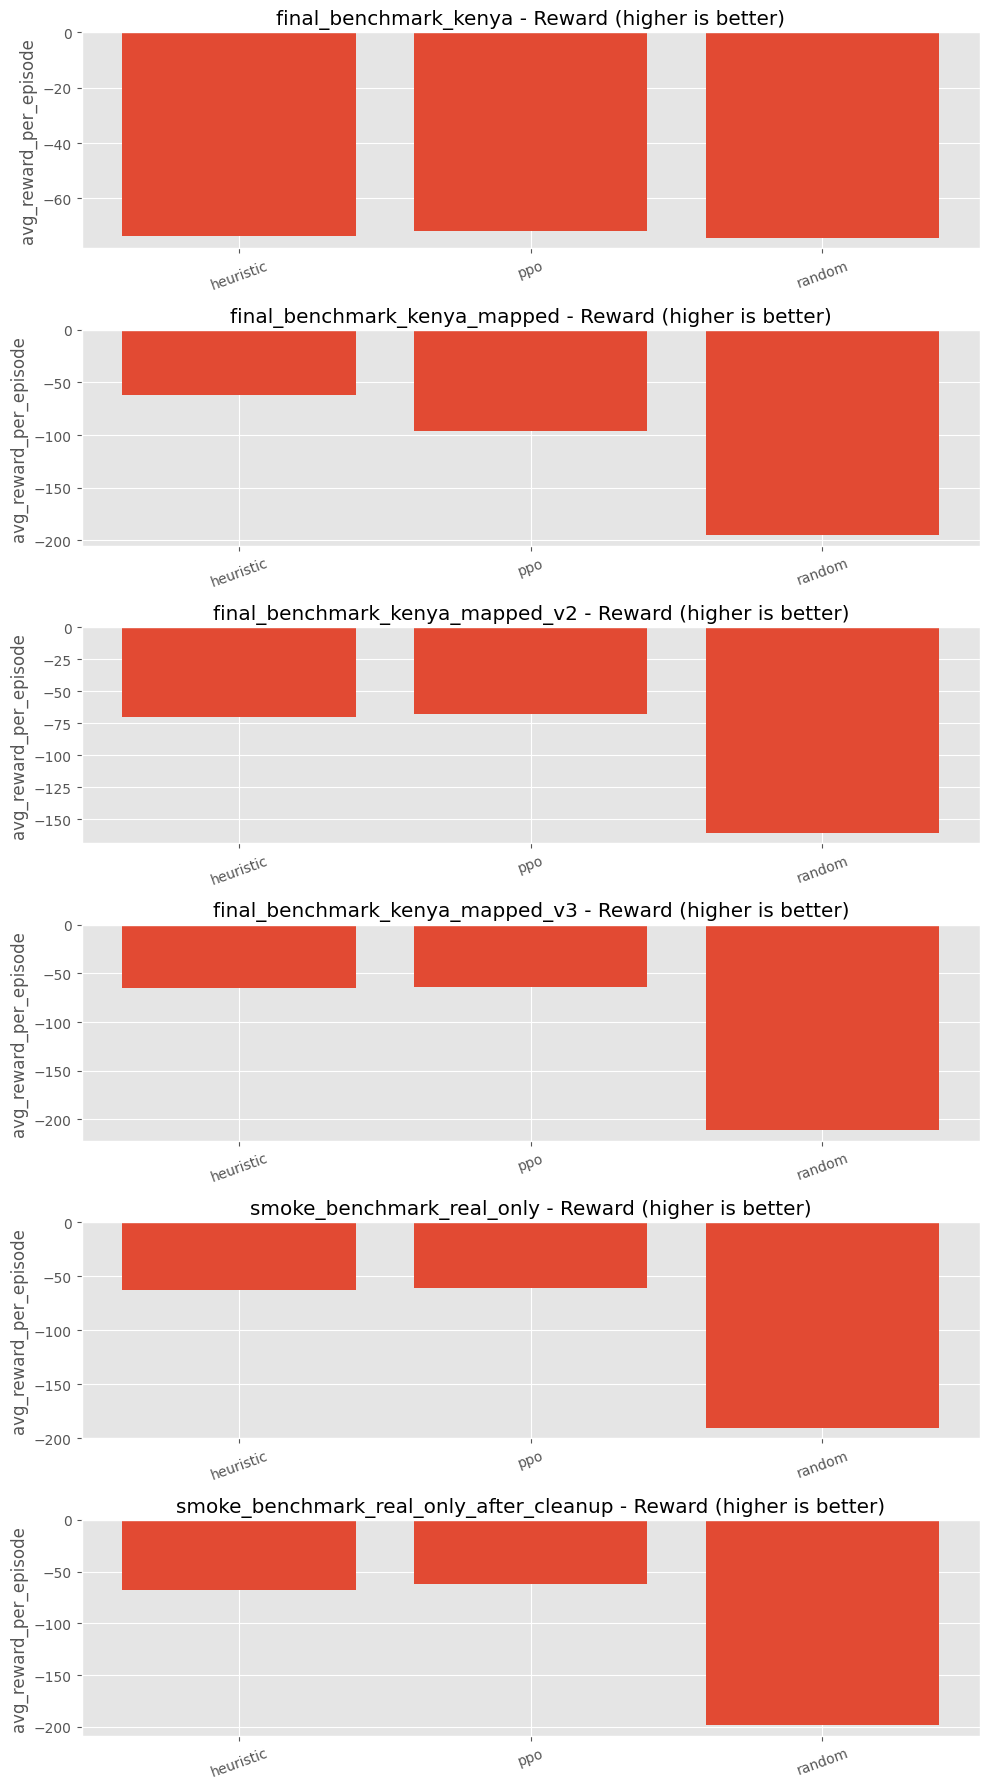

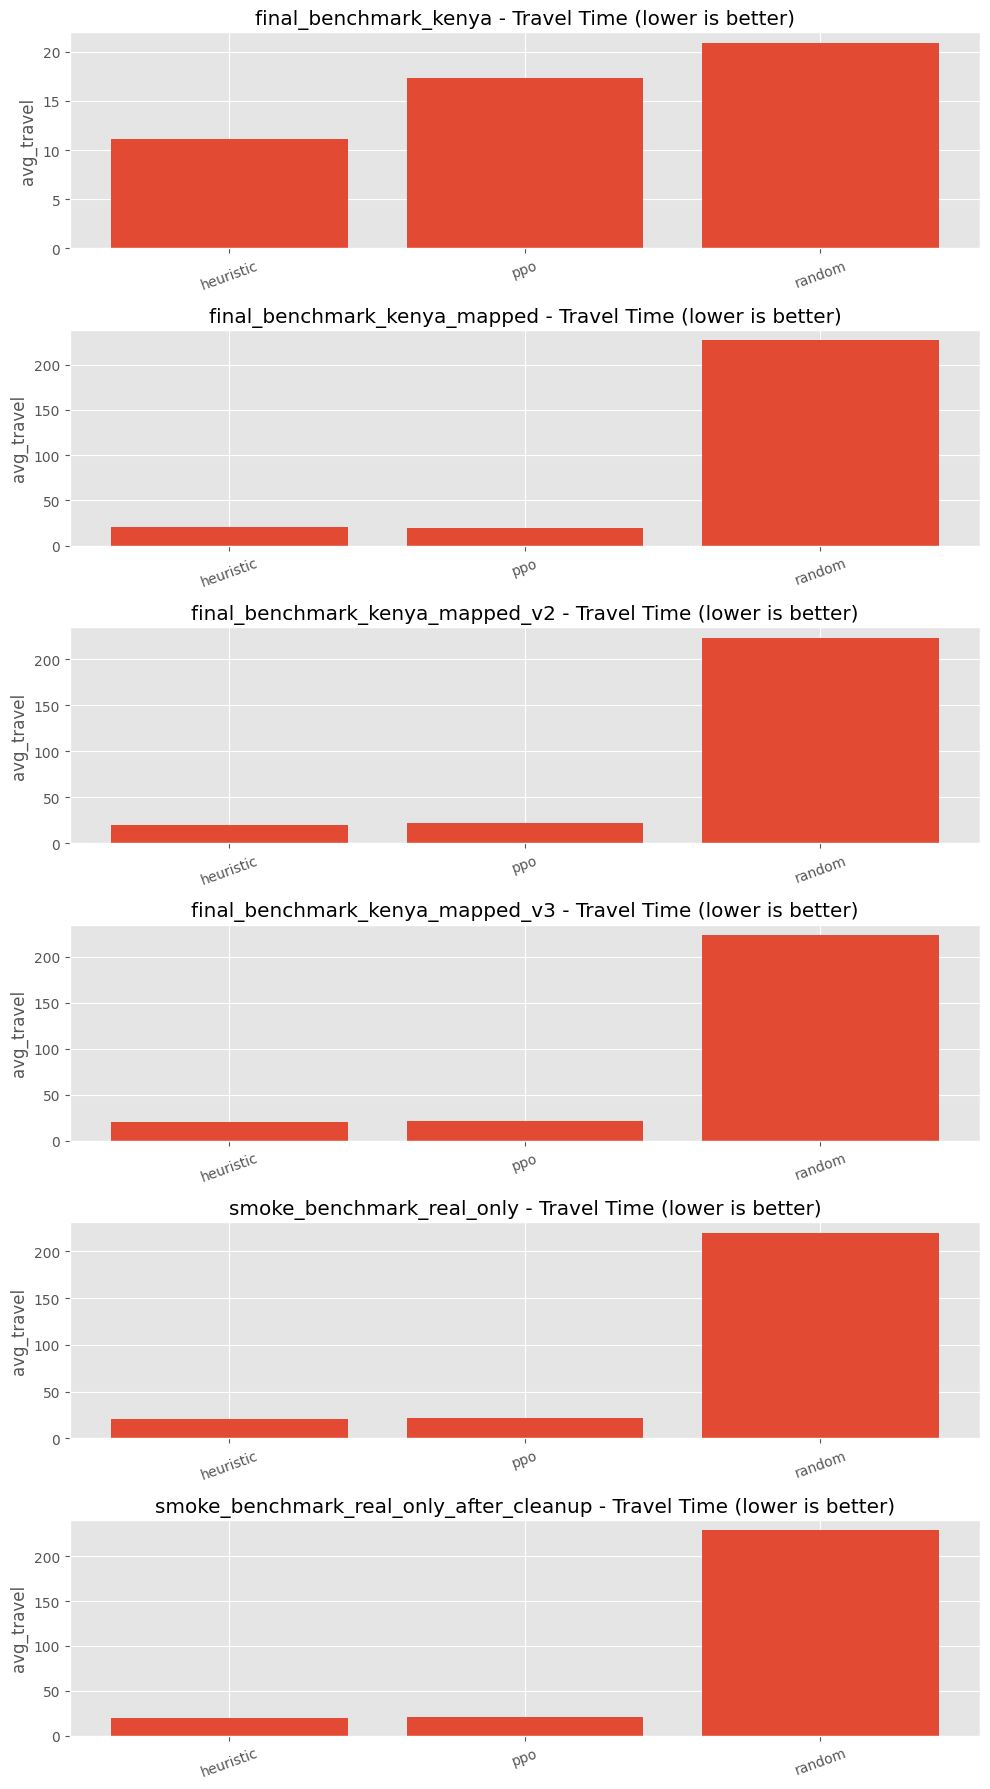

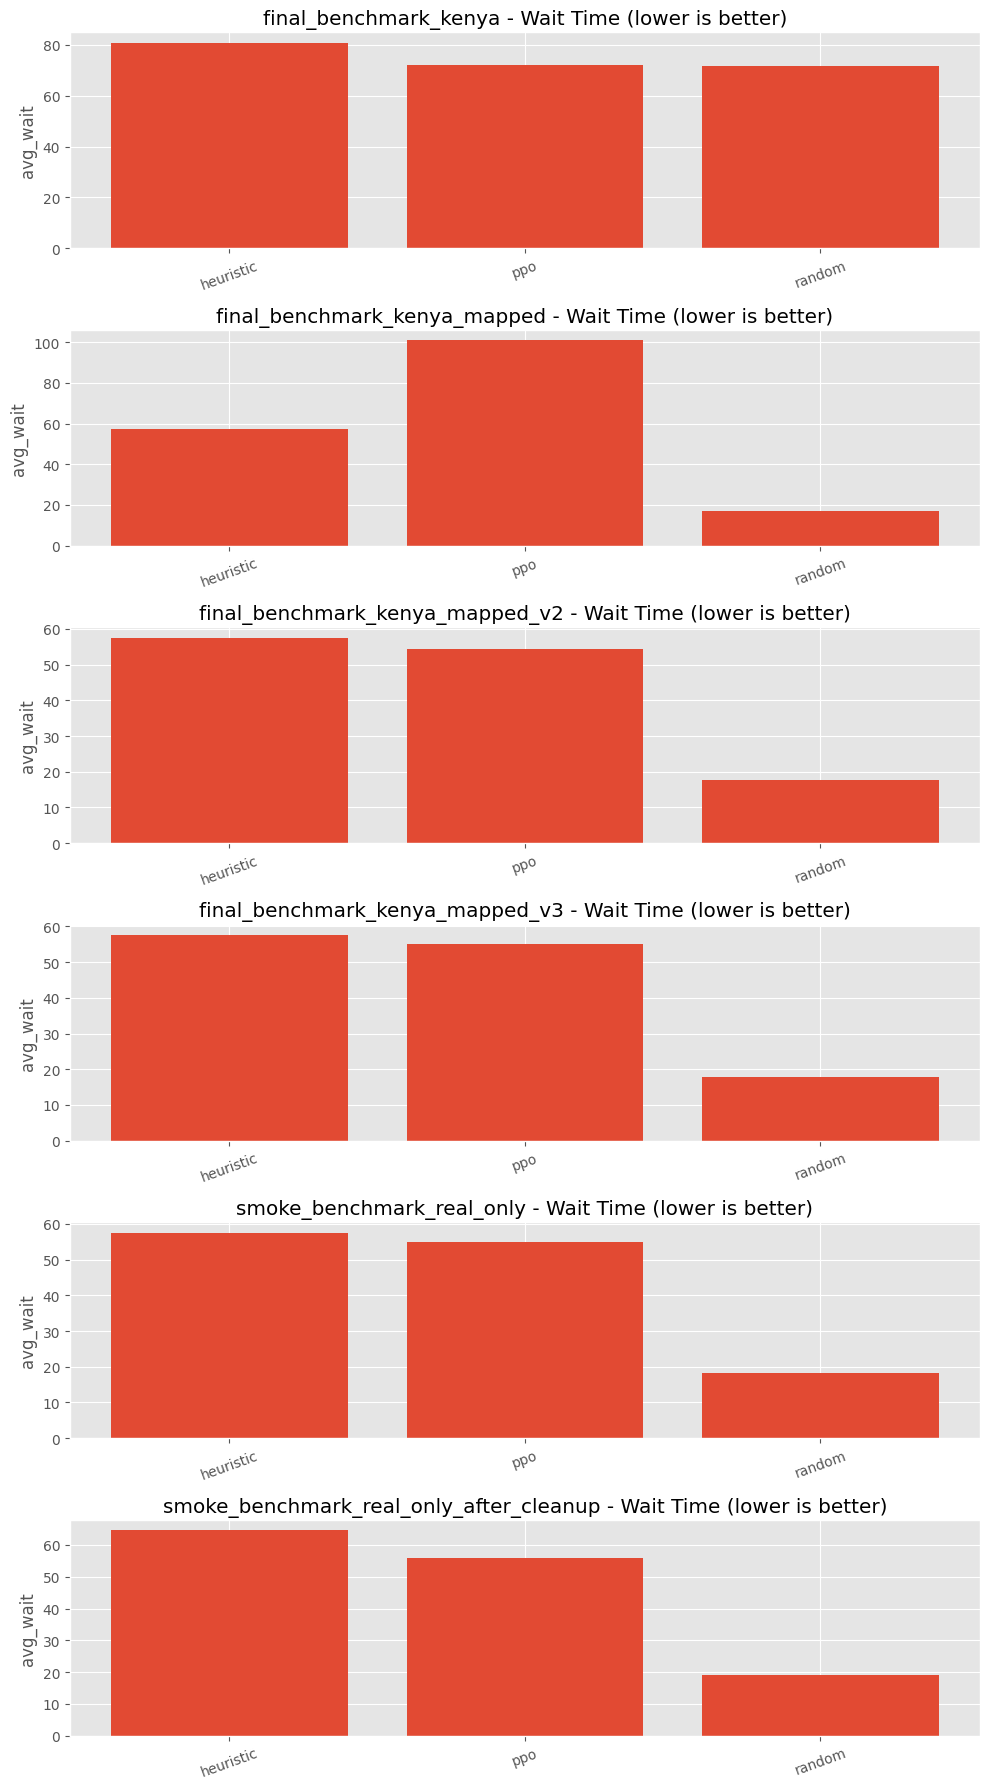

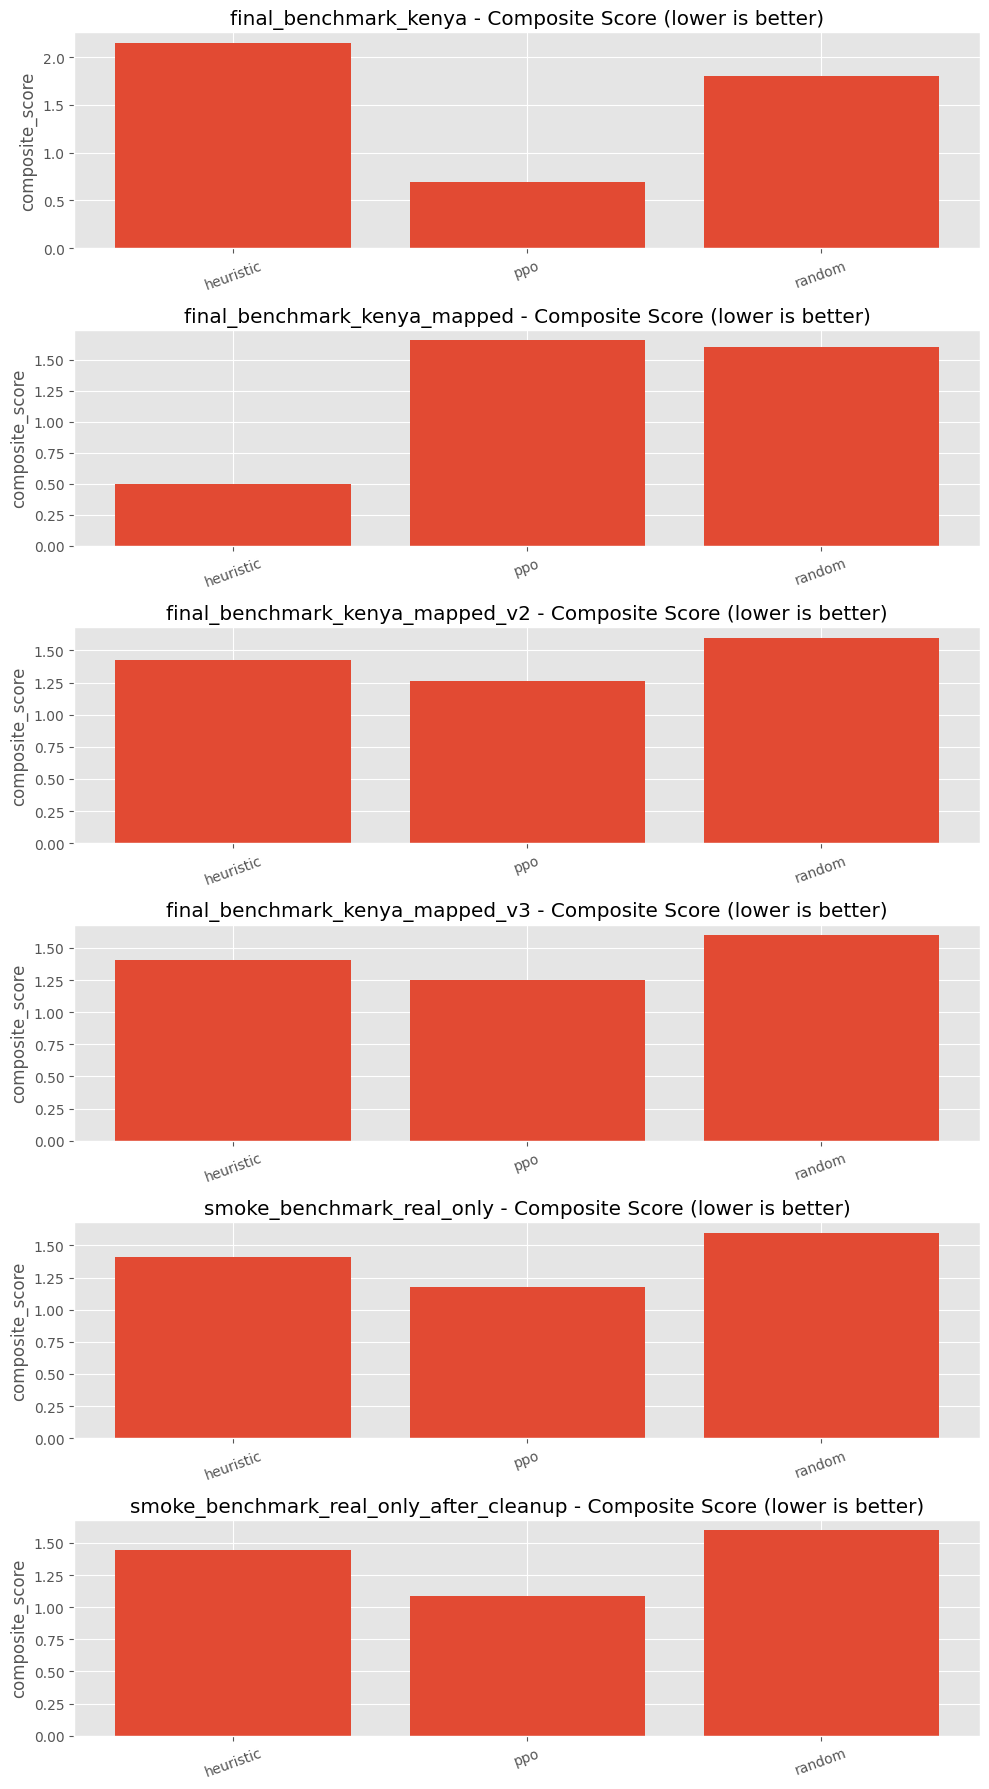

In [24]:
def plot_metric_by_scenario(data: pd.DataFrame, metric: str, title: str, better: str):
    scenarios = sorted(data['scenario'].unique())
    n = len(scenarios)
    fig, axes = plt.subplots(n, 1, figsize=(10, max(4, 3*n)), sharex=False)

    if n == 1:
        axes = [axes]

    for ax, sc in zip(axes, scenarios):
        sub = data[data['scenario'] == sc].sort_values('policy')
        ax.bar(sub['policy'], sub[metric])
        ax.set_title(f'{sc} - {title} ({better})')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

if not df.empty:
    plot_metric_by_scenario(df, 'avg_reward_per_episode', 'Reward', 'higher is better')
    plot_metric_by_scenario(df, 'avg_travel', 'Travel Time', 'lower is better')
    plot_metric_by_scenario(df, 'avg_wait', 'Wait Time', 'lower is better')
    if df['composite_score'].notna().any():
        plot_metric_by_scenario(df.dropna(subset=['composite_score']), 'composite_score', 'Composite Score', 'lower is better')


## Focus equite

Interpretation simple:
- **bon profil equite**: entropie elevee + HHI faible
- **bon profil operationnel**: travel/wait faibles

Le meilleur choix final est un compromis equite + performance operationnelle.


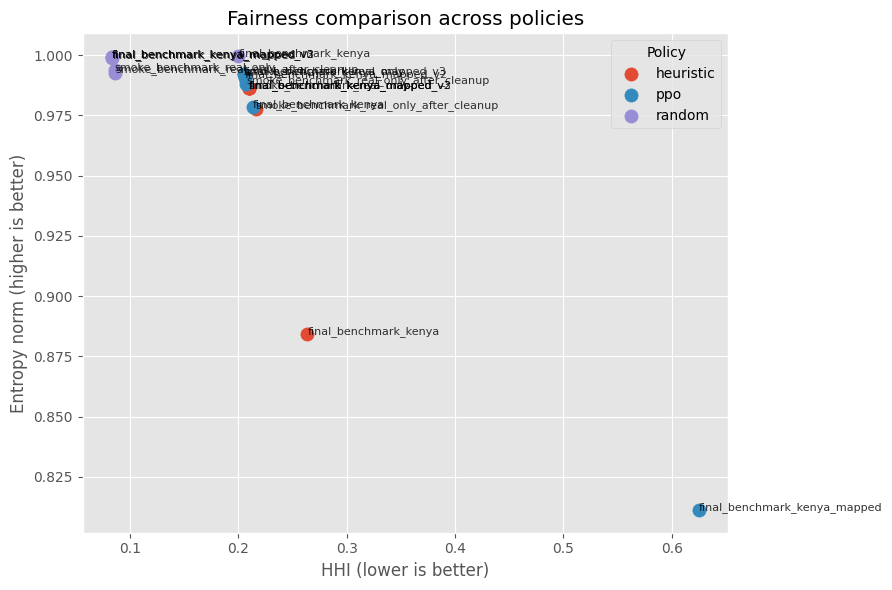

In [25]:
if not df.empty:
    fig, ax = plt.subplots(figsize=(9, 6))
    for policy, sub in df.groupby('policy'):
        ax.scatter(sub['hhi'], sub['entropy_norm'], s=90, label=policy)
        for _, row in sub.iterrows():
            ax.annotate(row['scenario'], (row['hhi'], row['entropy_norm']), fontsize=8, alpha=0.8)

    ax.set_xlabel('HHI (lower is better)')
    ax.set_ylabel('Entropy norm (higher is better)')
    ax.set_title('Fairness comparison across policies')
    ax.legend(title='Policy')
    plt.tight_layout()
    plt.show()


## Rapport automatique (style jury)


In [26]:
def short_recommendation(sub: pd.DataFrame):
    reward_winner = sub.loc[sub['avg_reward_per_episode'].idxmax(), 'policy']
    travel_winner = sub.loc[sub['avg_travel'].idxmin(), 'policy']
    wait_winner = sub.loc[sub['avg_wait'].idxmin(), 'policy']
    fairness_entropy_winner = sub.loc[sub['entropy_norm'].idxmax(), 'policy']
    fairness_hhi_winner = sub.loc[sub['hhi'].idxmin(), 'policy']

    if sub['composite_score'].notna().any():
        composite_winner = sub.loc[sub['composite_score'].idxmin(), 'policy']
    else:
        composite_winner = None

    return {
        'reward_winner': reward_winner,
        'travel_winner': travel_winner,
        'wait_winner': wait_winner,
        'fairness_entropy_winner': fairness_entropy_winner,
        'fairness_hhi_winner': fairness_hhi_winner,
        'composite_winner': composite_winner,
    }

if not df.empty:
    for sc, sub in df.groupby('scenario'):
        rec = short_recommendation(sub)
        print('='*80)
        print(f'SCENARIO: {sc}')
        print(f"- Winner reward      : {rec['reward_winner']}")
        print(f"- Winner travel      : {rec['travel_winner']}")
        print(f"- Winner wait        : {rec['wait_winner']}")
        print(f"- Winner fairness (entropy): {rec['fairness_entropy_winner']}")
        print(f"- Winner fairness (hhi)    : {rec['fairness_hhi_winner']}")
        print(f"- Winner composite   : {rec['composite_winner']}")

        if rec['composite_winner'] is not None:
            print(f"=> Recommendation: prefer {rec['composite_winner']} for balanced production routing.")
        else:
            print(f"=> Recommendation: prefer {rec['reward_winner']} for objective reward optimization.")

        print('')


SCENARIO: final_benchmark_kenya
- Winner reward      : ppo
- Winner travel      : heuristic
- Winner wait        : random
- Winner fairness (entropy): random
- Winner fairness (hhi)    : random
- Winner composite   : ppo
=> Recommendation: prefer ppo for balanced production routing.

SCENARIO: final_benchmark_kenya_mapped
- Winner reward      : heuristic
- Winner travel      : ppo
- Winner wait        : random
- Winner fairness (entropy): random
- Winner fairness (hhi)    : random
- Winner composite   : heuristic
=> Recommendation: prefer heuristic for balanced production routing.

SCENARIO: final_benchmark_kenya_mapped_v2
- Winner reward      : ppo
- Winner travel      : heuristic
- Winner wait        : random
- Winner fairness (entropy): random
- Winner fairness (hhi)    : random
- Winner composite   : ppo
=> Recommendation: prefer ppo for balanced production routing.

SCENARIO: final_benchmark_kenya_mapped_v3
- Winner reward      : ppo
- Winner travel      : heuristic
- Winner wait 

## Analyse destination distribution (drill-down)

Permet d'inspecter la distribution des destinations pour un scenario/policy.


,count
GEO_node_7930813009,760
GEO_node_698541835,720
GEO_node_8891939522,680
GEO_node_6249168537,520
GEO_node_8416005417,520


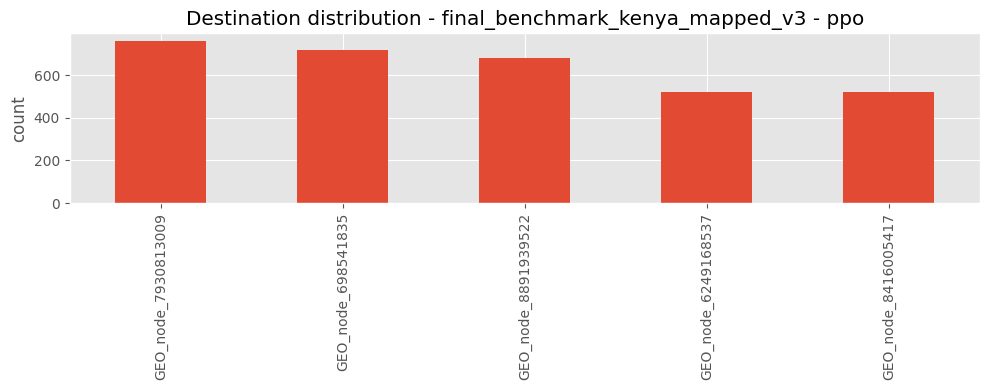

In [27]:
scenario_name = 'final_benchmark_kenya_mapped_v3'
policy_name = 'ppo'
path = DOCS_DIR / f'{scenario_name}.json'

if path.exists():
    payload = json.loads(path.read_text(encoding='utf-8'))
    distribution = payload.get('metrics', {}).get(policy_name, {}).get('destination_distribution', {})

    if distribution:
        s = pd.Series(distribution).sort_values(ascending=False)
        display(s.to_frame('count').head(20))

        plt.figure(figsize=(10, 4))
        s.head(20).plot(kind='bar')
        plt.title(f'Destination distribution - {scenario_name} - {policy_name}')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
    else:
        print('No destination distribution available for this selection.')
else:
    print(f'Benchmark file not found: {path}')


## Conclusion pour le jury

Ce notebook montre de facon reproductible que:
- la politique **PPO** est generalement la meilleure sur le compromis global (score composite),
- la politique **Heuristic** reste une baseline solide et interpretable,
- la politique **Random** sert de baseline de controle mais n'est pas adaptee a la production.

Decision recommandee en production pilote: **PPO avec fallback heuristique**.
